In [1]:
import jax.numpy as jnp
from jax import random, jit, vmap
import matplotlib.pyplot as plt

from quantum_error_correction_code import SurfaceCode
from deformation_handler import DeformationManager

key = random.key(42)

In [2]:
p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])

CODE_DISTANCE = 3
# CODE_DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)
CODE_DEFORMATION = jnp.array([2,0,2,3,2,3,2,0,2])
# CODE_DEFORMATION = jnp.kron(jnp.ones((3,3), dtype=jnp.int32), CODE_DEFORMATION.reshape((3,3))).flatten()

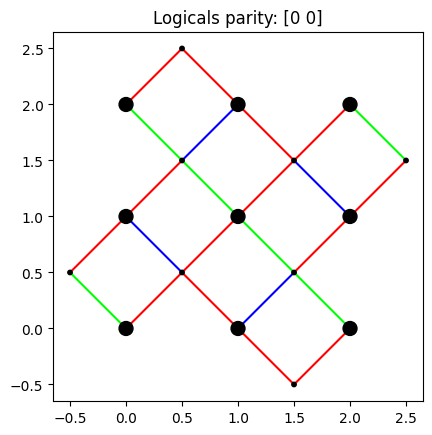

Logical X:
 [[1 1 1 0 1 0 1 1 1]
 [0 0 0 1 0 1 0 0 0]]
Logical Z:
 [[1 0 1 1 1 1 1 0 1]
 [1 1 1 0 1 0 1 1 1]]

[[[[0. 1. 0.]
   [0. 0. 0.]
   [0. 1. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 0. 1.]
   [0. 1. 0.]
   [1. 0. 1.]]

  [[0. 0. 0.]
   [1. 0. 1.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


In [3]:
L = CODE_DISTANCE

dm = DeformationManager(jnp.arange(6), L)
deformation, key = dm.random_deformation(key)
# deformation = jnp.array([0,3])[jnp.arange(L**2)%2]
# deformation = 1*jnp.ones(L**2, dtype=jnp.int32)
deformation = CODE_DEFORMATION

code = SurfaceCode(L)
parity_info = code.deformation_parity_info(deformation)
code.show(parity_info)
# print(code.show_latex_code(parity_info, deformation))
print("Logical X:\n", parity_info[2])
print("Logical Z:\n", parity_info[3])
print()
print(code.deformation_image(deformation))

In [4]:
def shot(circuit, syndromes):
    print(f"{'qubit idx':^{3*syndromes+1}s}")
    print("".join(f"{str(i):^3s}" for i in range(syndromes)))
    sample = circuit.compile_sampler().sample(1)[0]
    for i in range(len(sample) // syndromes):
        print("".join(" ⬤ " if e else " ∙ " for e in sample[i*syndromes:(i+1)*syndromes]))

def detect_shot(circuit, syndromes):
    print(f"{'qubit idx':^{3*syndromes+1}s}")
    print("".join(f"{str(i):^3s}" for i in range(syndromes)))
    samples = circuit.compile_detector_sampler().sample(1)[0]
    for i in range(len(samples) // syndromes):
        print("".join(" ⬤ " if e else " ∙ " for e in samples[i*syndromes:(i+1)*syndromes]))

In [5]:
rounds = L
circuit = code.to_stim(parity_info, rounds,
    idelig_T1_us = 1000,
    idelig_T2_us = 10,
    single_qubit_error_rate = 2.4E-4,
    two_qubit_error_rate = 1.2E-2,
    meas_error_rate = 1.25E-2,
    reset_error_rate = 2.4E-4,
    meas_time_us = 1.0,
    single_qubit_gate_time_us = 0.05,
    two_qubit_gate_time_us = 0.4,
)

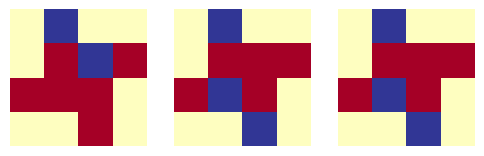

In [6]:
import numpy as np
import matplotlib.pyplot as plt

samples = jnp.array(circuit.compile_detector_sampler().sample(1)[0].astype(int).reshape((rounds, L**2-1)))
sample_vol = jnp.zeros((rounds, (L+1)**2))
sample_vol = sample_vol.at[:, jnp.ravel(code.mask)].set(samples).reshape((rounds, L+1, L+1))

data = sample_vol  # Example binary data

fig, axes = plt.subplots(1, L, figsize=(L * 2, 4))  # One row of L slices
for i in range(L):
    axes[i].imshow(data[i+1, :, :].at[~code.mask].set(.5), cmap='RdYlBu', vmin=0, vmax=1, origin='lower')
    axes[i].axis('off')
plt.show()


In [7]:
shot(circuit, L**2-1)

        qubit idx        
 0  1  2  3  4  5  6  7 
 ⬤  ∙  ∙  ∙  ∙  ∙  ∙  ∙ 
 ⬤  ∙  ∙  ∙  ∙  ∙  ⬤  ∙ 
 ⬤  ∙  ⬤  ∙  ∙  ∙  ⬤  ∙ 
 ⬤  ∙  ∙  ⬤  ∙  ∙  ∙  ∙ 
 ∙  ⬤  ⬤  ⬤  ∙  ⬤  ⬤  ∙ 


In [8]:
detect_shot(circuit, L**2-1)

        qubit idx        
 0  1  2  3  4  5  6  7 
 ∙  ∙  ⬤  ⬤  ∙  ∙  ∙  ∙ 
 ∙  ∙  ⬤  ⬤  ∙  ⬤  ⬤  ⬤ 
 ⬤  ⬤  ∙  ∙  ∙  ∙  ∙  ∙ 


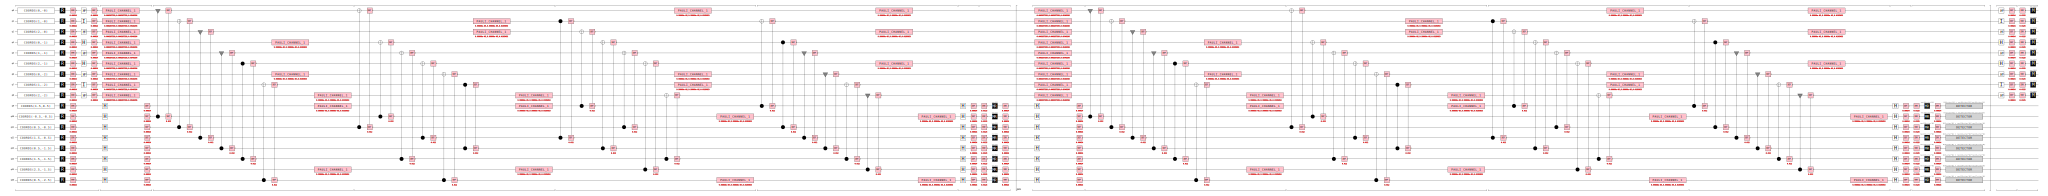

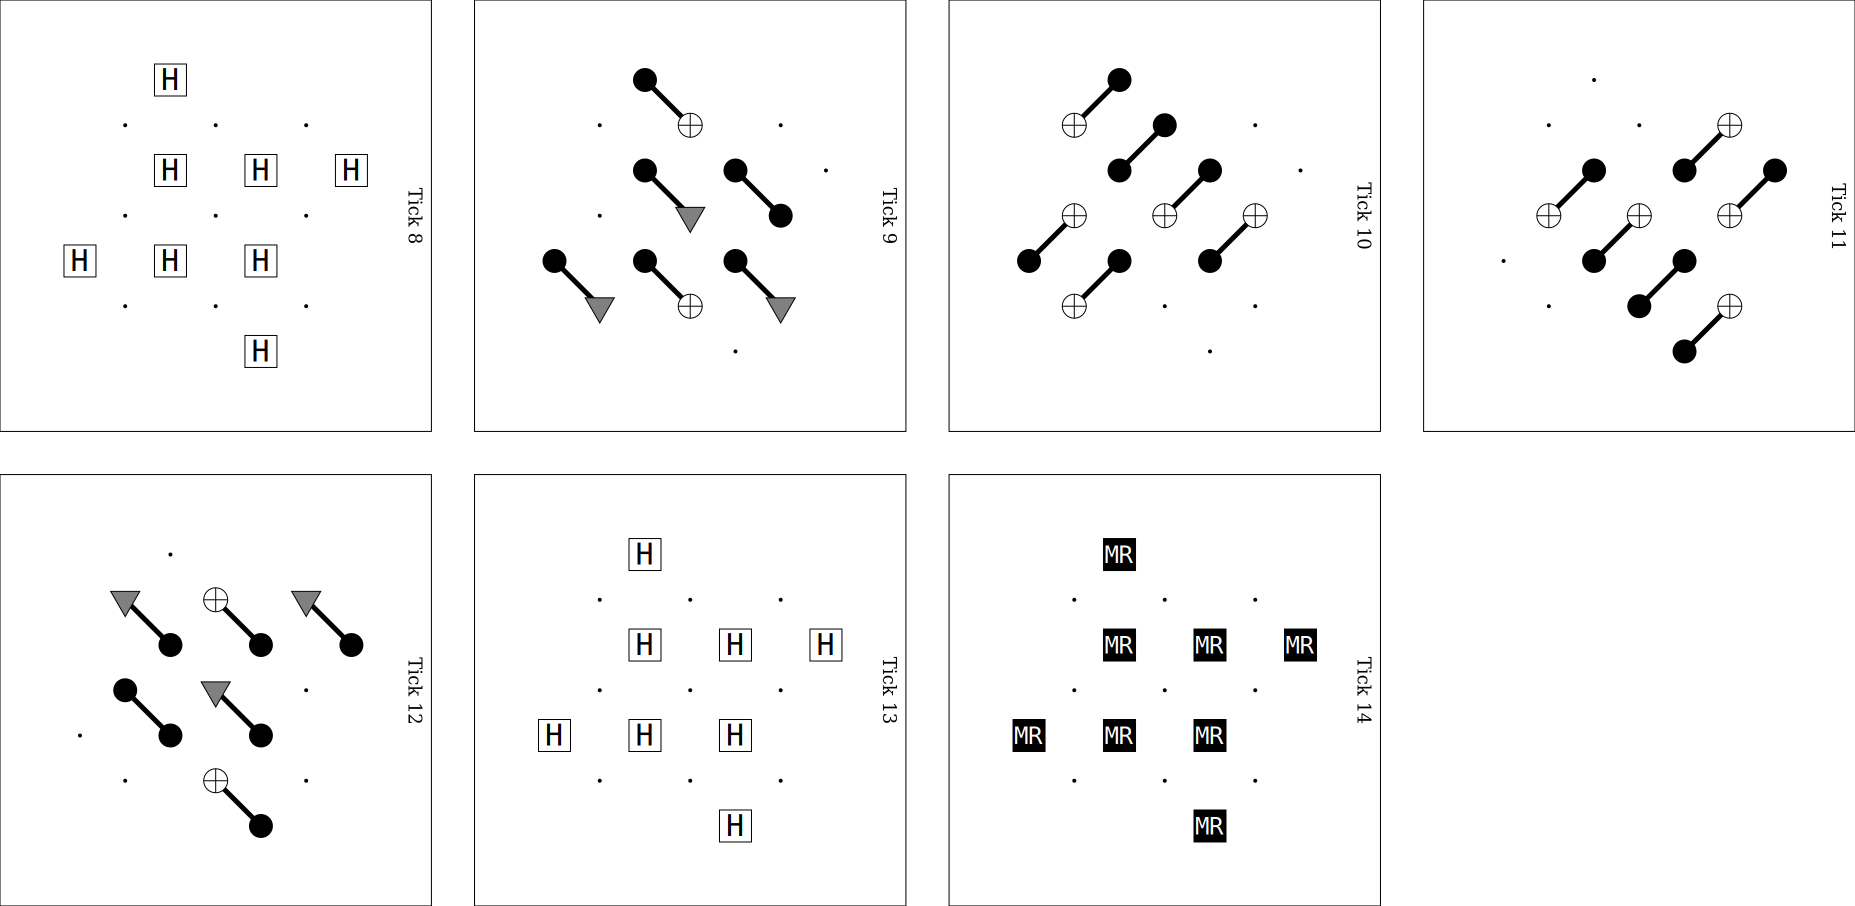

In [9]:
display(circuit.diagram('timeline-svg'))
display(code.to_stim(parity_info, 2).diagram("timeslice-svg", rows=2, tick=range(8, 15)))
# display(code.to_stim(parity_info, 2).diagram("detslice-with-ops-svg", rows=1, tick=range(8, 15)))

Logical X:
 [[1 1 1 0 1 0 1 1 1]
 [0 0 0 1 0 1 0 0 0]]
Logical Z:
 [[1 0 1 1 1 1 1 0 1]
 [1 1 1 0 1 0 1 1 1]]


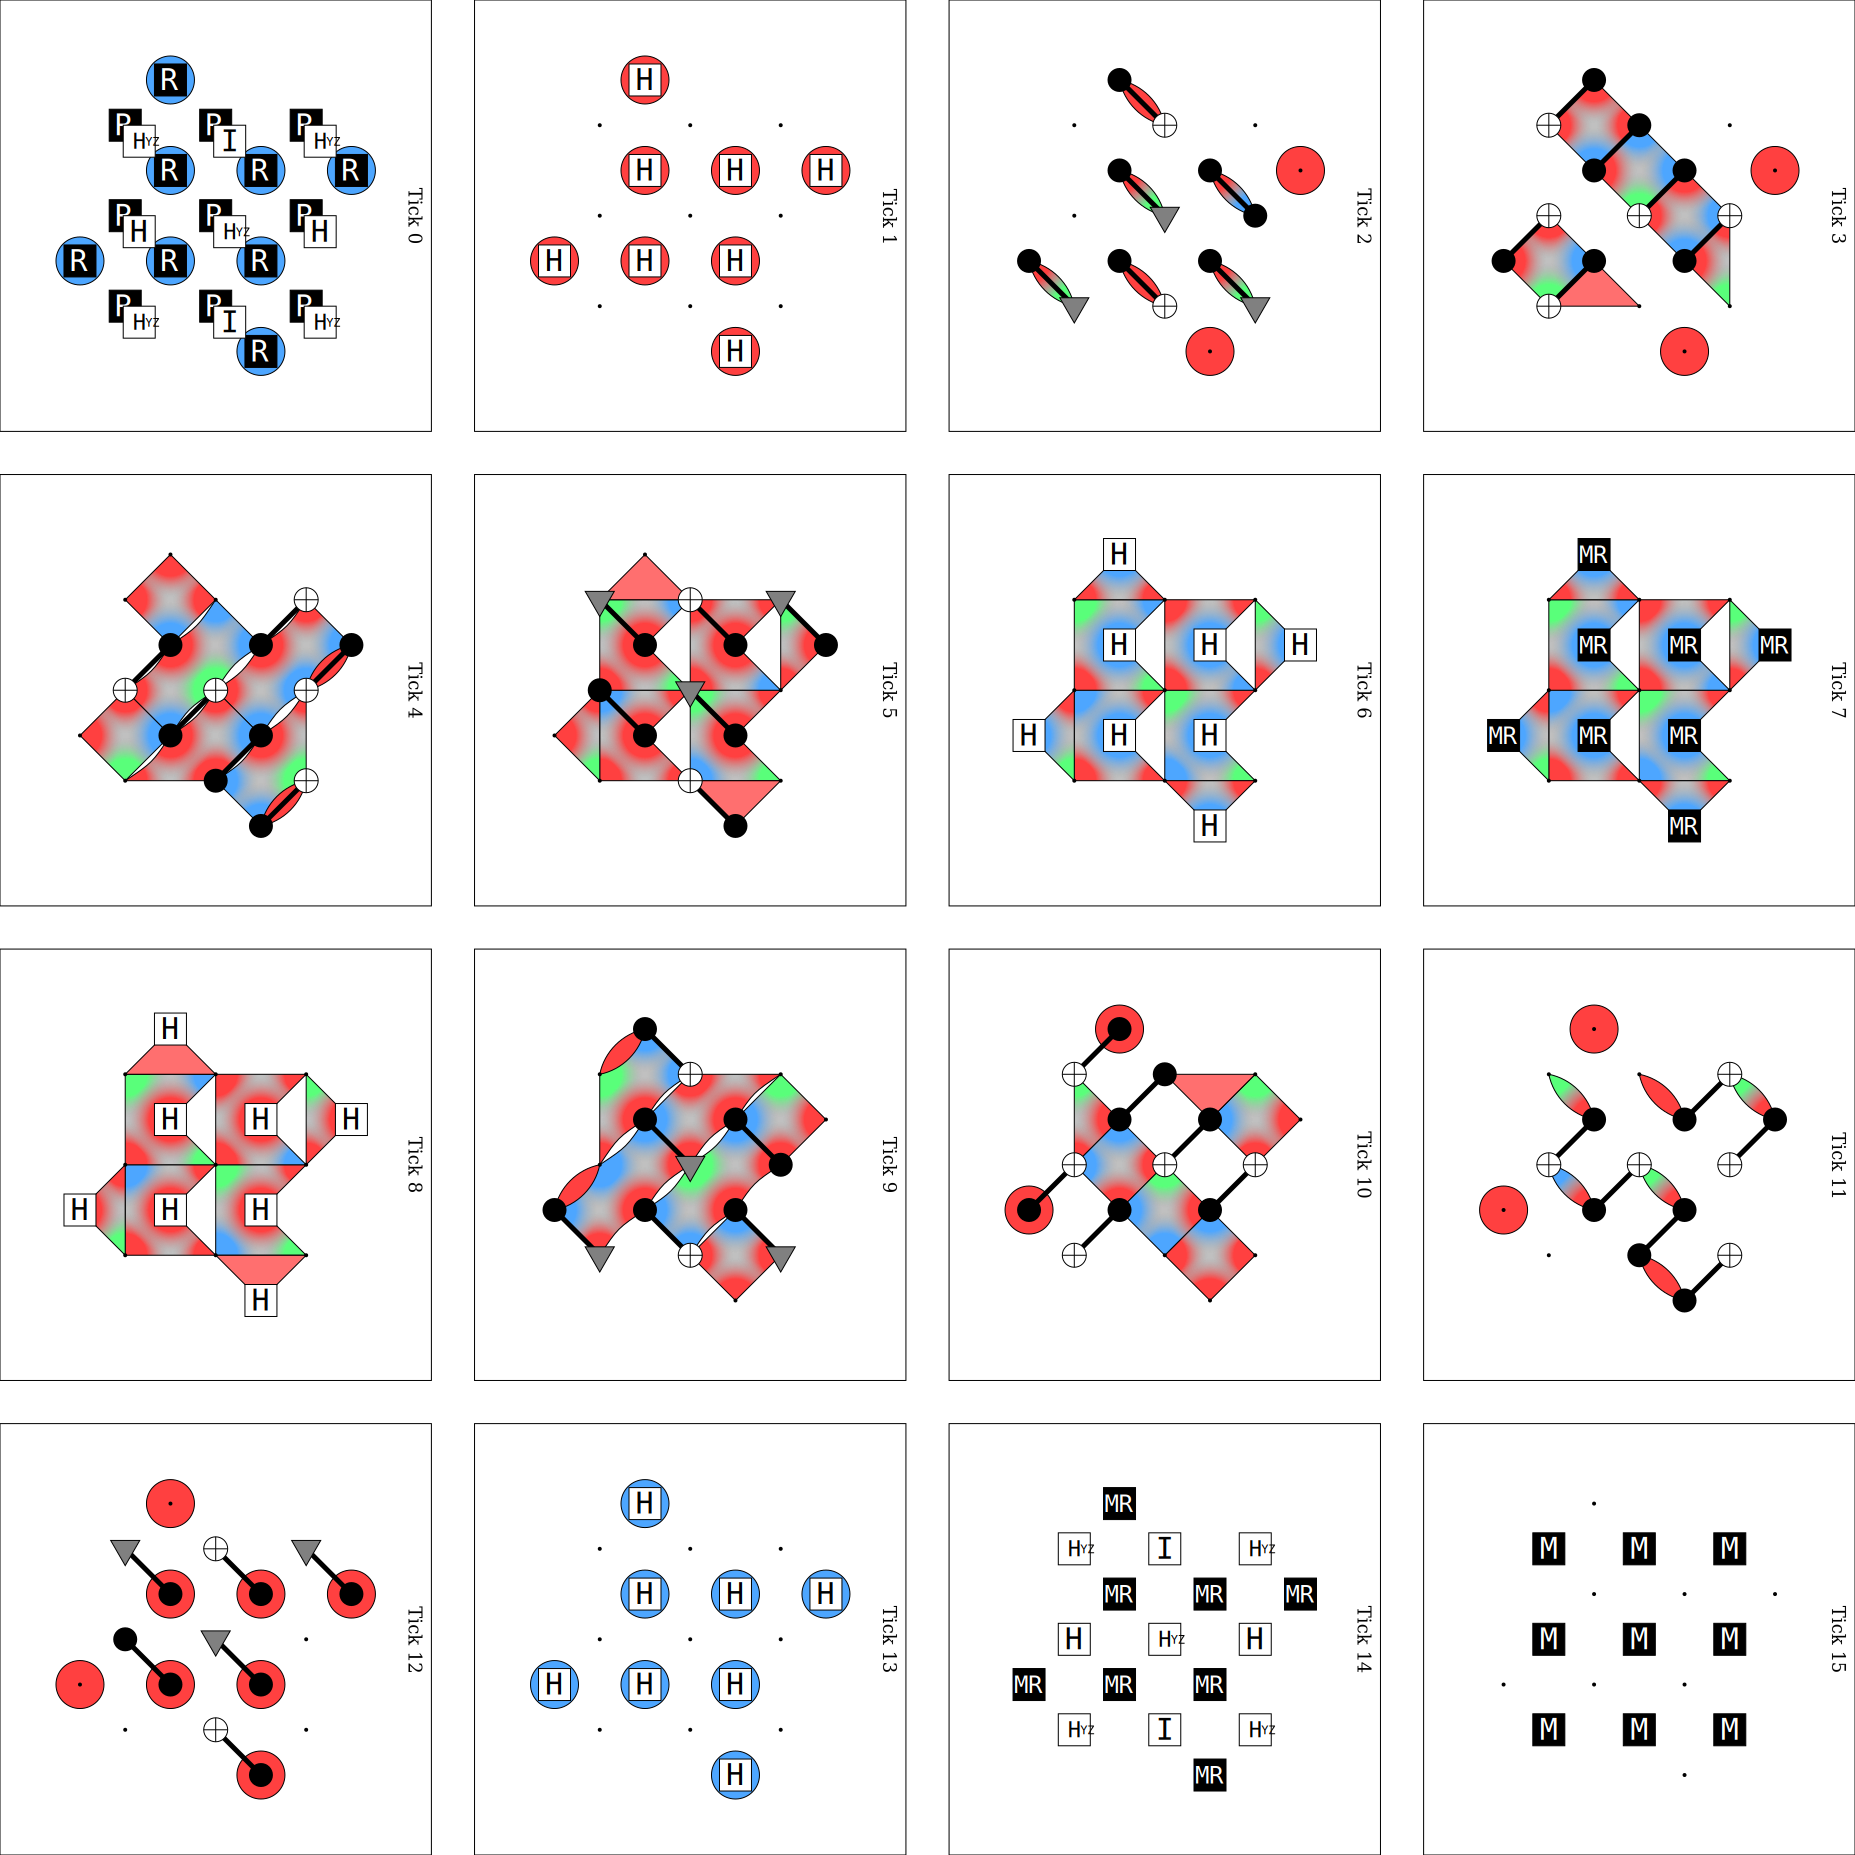

In [10]:
print("Logical X:\n", parity_info[2])
print("Logical Z:\n", parity_info[3])
display(code.to_stim(parity_info, 1, init_basis="Z").diagram("detslice-with-ops-svg"))

In [11]:
key = random.key(42)

X-error: [0 0 0 0 0 0 0 0 0]
Z-error: [0 0 0 0 0 0 0 0 0]
Syndrome: [0 0 0 0 0 0 0 0]


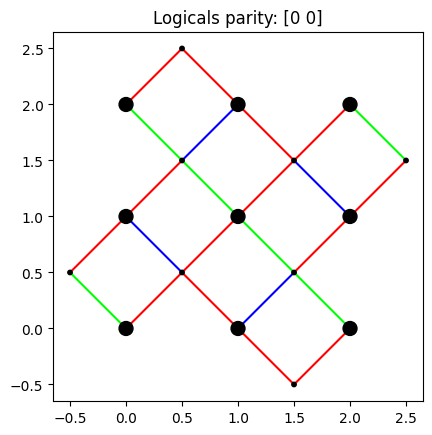

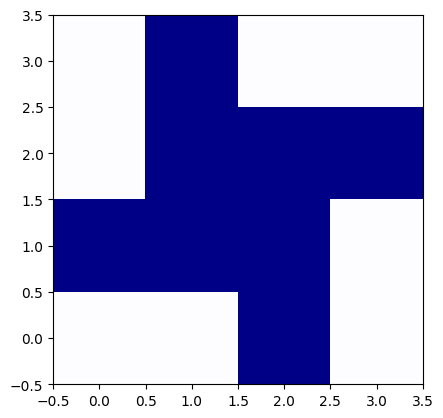

In [12]:
subkey, key = random.split(key)
error = code.error(
    subkey,
    ERROR_PROBS,
)
print("X-error:",error[0].astype(int))
print("Z-error:",error[1].astype(int))
syndrome, logicals = code.syndrome(error, parity_info)
print("Syndrome:",syndrome)

code.show(parity_info, error)

img_syndrome, _ = code.syndrome_img(error, parity_info)

plt.figure()
plt.imshow(img_syndrome, origin='lower', vmin=-1.2, vmax=1.2, cmap="seismic_r")
plt.show()

In [13]:
BATCH_SIZE = 1000

@jit
def get_data(
    datakey,
    probabilities: jnp.ndarray,
):
    datakey = random.split(datakey, num=BATCH_SIZE+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(datakey[:-1], probabilities)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], logicals, datakey[-1]

In [14]:
datakey = random.key(42)

In [15]:
img_deformation, logicals, datakey = get_data(datakey, ERROR_PROBS)

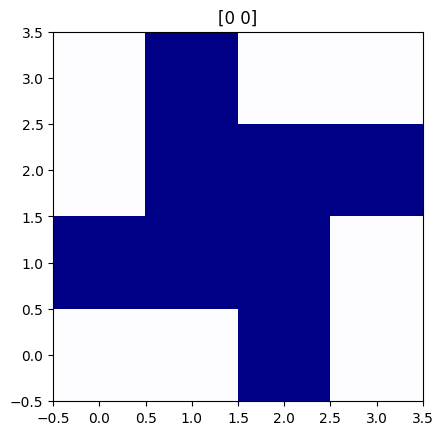

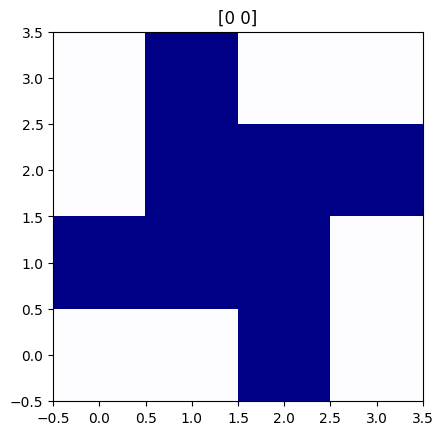

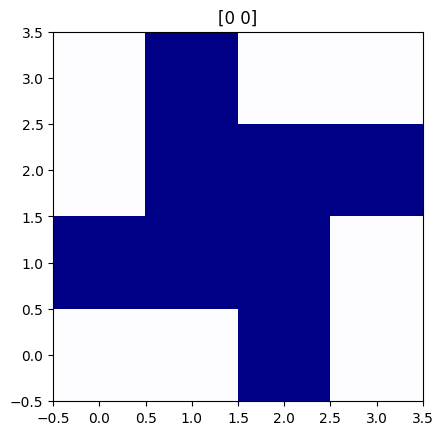

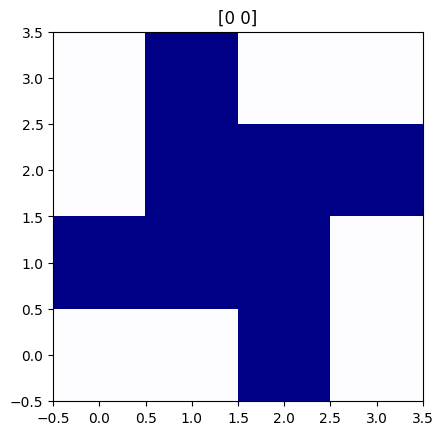

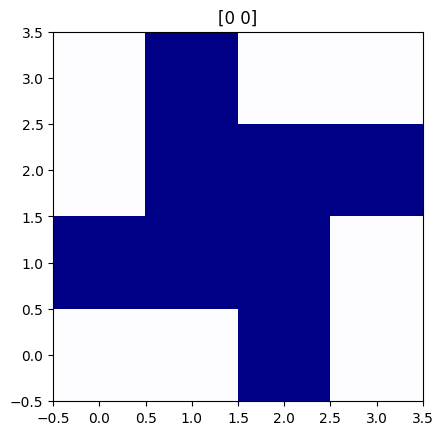

In [16]:
for img_syndrome, logi in zip(img_deformation[:5], logicals[:5]):
    plt.figure()
    plt.imshow(img_syndrome[0], origin='lower', vmin=-1.2, vmax=1.2, cmap="seismic_r")
    plt.title(logi)
    plt.show()